In [35]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [36]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import pandas as pd

In [38]:
import xgboost as xgb

In [40]:
#load gray npy array
tr_im_in = np.load('array_file_gray.npy')

tr_lab_in = np.load('y_train_types.npy')

len(tr_im_in), tr_im_in.shape, len(tr_lab_in), tr_lab_in.shape

(2288, (2288, 420, 450), 2288, (2288,))

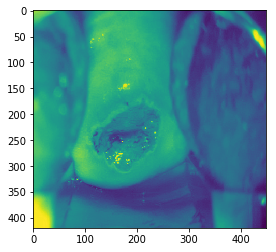

In [60]:
plt.imshow(tr_im_in[0])

In [41]:
#combine the labels and the images in one data frame

train_data_df = pd.DataFrame({'label': tr_lab_in, 'images': list(tr_im_in)}, columns=['label', 'images'])

#shape of data frame
train_data_df.shape, train_data_df['images'].shape, train_data_df['label'].shape

((2288, 2), (2288,), (2288,))

In [42]:
#parition df to separate the labels from image data
data=train_data_df['images']
label=train_data_df['label']

#chek shape
data.shape, label.shape

((2288,), (2288,))

In [43]:
#change Type_1, Type_2, Type_3 to 1,2,3
label = label.replace(["Type_1", "Type_2", "Type_3"],[0,1,2]).astype('category')

In [44]:
label.shape, label[0:4], label[1500:1503], label[2285:2288]

((2288,), 0    0
 1    0
 2    0
 3    0
 Name: label, dtype: category
 Categories (3, int64): [0, 1, 2], 1500    1
 1501    1
 1502    1
 Name: label, dtype: category
 Categories (3, int64): [0, 1, 2], 2285    2
 2286    2
 2287    2
 Name: label, dtype: category
 Categories (3, int64): [0, 1, 2])

In [45]:
#separate the df into train and validation set

from sklearn.model_selection import train_test_split

train_data, val_data, train_label, val_label = train_test_split(data, label, test_size=0.2, random_state=123 )

#check length to verify correct partition size
len(train_data), len(val_data), len(train_label), len(val_label)

(1830, 458, 1830, 458)

In [46]:
#return partitioned df back to array
train_data = np.array(train_data.tolist())
val_data = np.array(val_data.tolist())

train_label = np.array(train_label.tolist())
val_label = np.array(val_label.tolist())



#this will turn the image data to an array from original df: train_data_df['images'].  
#not used here
#train_data = np.array(train_data_df['images'].tolist())


#check shape
print ('Training data shape: ', train_data.shape, train_label.shape)
print ('Validation data shape: ', val_data.shape, val_label.shape)

classes = np.unique(train_label)
nClasses = len(classes)

print ('Total number of outputs: ', nClasses)
print ('Output classes: ', classes)

Training data shape:  (1830, 420, 450) (1830,)
Validation data shape:  (458, 420, 450) (458,)
Total number of outputs:  3
Output classes:  [0 1 2]


In [47]:
#resize to be able to feed into CNN
from numpy import array
train_data = train_data.reshape(1830, 420, 450, 1)
train_label = train_label.reshape(1830, 1)

val_data = val_data.reshape(458, 420, 450, 1)
val_label = val_label.reshape(458, 1)

#check shape after re-size
print ('Training data shape: ', train_data.shape, train_label.shape)
print ('Validation data shape: ', val_data.shape, val_label.shape)

classes = np.unique(train_label)
nClasses = len(classes)

print ('Total number of outputs: ', nClasses)
print ('Output classes: ', classes)

Training data shape:  (1830, 420, 450, 1) (1830, 1)
Validation data shape:  (458, 420, 450, 1) (458, 1)
Total number of outputs:  3
Output classes:  [0 1 2]


In [ ]:
#to compare arrays (but they are no longer aligned due to random selection of 
#sameple so this has no value)

#array that has been converted back
#val_data[0:1]

#original array
#tr_im_in[0:1]

In [48]:
#find shape of the image data and create variable for the input shape

nRows, nCols, nDims = train_data.shape[1:]
train_data = train_data.reshape(train_data.shape[0], nRows, nCols, nDims)
val_data = val_data.reshape(val_data.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)


In [49]:
#change to float data type
train_data = train_data.astype('float32')
val_data = val_data.astype('float32')

In [50]:
#scale data to be between 0 and 1
train_data /= 255
val_data /= 255

In [51]:
train_label[0]

array([1])

In [52]:
from keras.utils import to_categorical

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
val_labels_one_hot = to_categorical(val_label)

# Display the change for category label using one-hot encoding
print('Original label 0 : ', train_label[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

Original label 0 :  [1]
After conversion to categorical ( one-hot ) :  [0. 1. 0.]


In [53]:
#code from: https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/

#setup the network
from sklearn.manifold import TSNE

#other activation functions: sigmoid, tanh, K.tanh
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
 
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='sigmoid'))
    model.add(Conv2D(64, (3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

In [54]:
#training the network

model1 = createModel()
batch_size = 100
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
 
history = model1.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(val_data, val_labels_one_hot))
 

Train on 1830 samples, validate on 458 samples
Epoch 1/50
1830/1830 [==============================] - 1799s 983ms/step - loss: 10.2936 - acc: 0.3279 - val_loss: 11.2967 - val_acc: 0.2991
Epoch 2/50
1830/1830 [==============================] - 1805s 986ms/step - loss: 10.7102 - acc: 0.3355 - val_loss: 11.2967 - val_acc: 0.2991
Epoch 3/50
1830/1830 [==============================] - 1783s 975ms/step - loss: 10.7102 - acc: 0.3355 - val_loss: 11.2967 - val_acc: 0.2991
Epoch 4/50
1830/1830 [==============================] - 1843s 1s/step - loss: 10.7102 - acc: 0.3355 - val_loss: 11.2967 - val_acc: 0.2991
Epoch 5/50
1830/1830 [==============================] - 1847s 1s/step - loss: 10.7102 - acc: 0.3355 - val_loss: 11.2967 - val_acc: 0.2991
Epoch 6/50
1830/1830 [==============================] - 2111s 1s/step - loss: 10.7102 - acc: 0.3355 - val_loss: 11.2967 - val_acc: 0.2991
Epoch 7/50
1830/1830 [==============================] - 1936s 1s/step - loss: 10.7102 - acc: 0.3355 - val_loss: 11.2

In [55]:
#evaluate the model on the validation set
model1.evaluate(val_data, val_labels_one_hot)


#evaluate model on test data
#model1.evaluate(test_data, test_label)





458/458 [==============================] - 107s 234ms/step


[11.29674372610567, 0.29912663761965574]

Text(0.5,1,'Loss Curves')

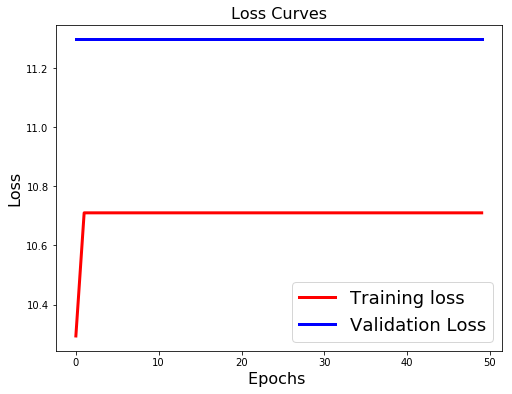

In [56]:
# Loss Curves

plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

Text(0.5,1,'Accuracy Curves')

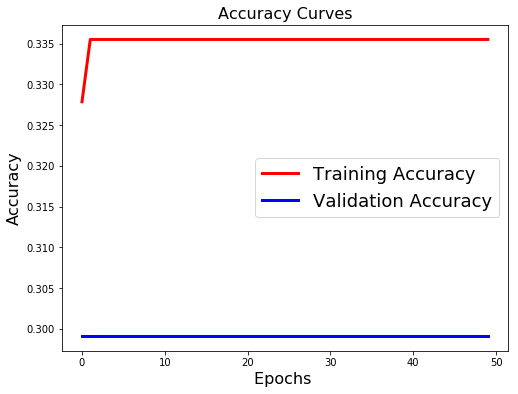

In [57]:
# Accuracy Curves

plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#perform data augmentation to flip images to create more samples

# from keras.preprocessing.image import ImageDataGenerator
 
# ImageDataGenerator(
#     rotation_range=10.,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.,
#     zoom_range=.1.,
#     horizontal_flip=True,
#     vertical_flip=True)

In [ ]:
#train the data with data augmentation  (if using this step, 
#don't use training section above)

# model2 = createModel()
 
# model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
 
# batch_size = 256
# epochs = 100
# datagen = ImageDataGenerator(
# #         zoom_range=0.2, # randomly zoom into images
# #         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images
 
# # Fit the model on the batches generated by datagen.flow().
# history2 = model2.fit_generator(datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
#                               steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
#                               epochs=epochs,
#                               validation_data=(test_data, test_labels_one_hot),
#                               workers=4)
 
# model2.evaluate(test_data, test_labels_one_hot)

In [ ]:
# Loss Curves for augmentation training

# plt.figure(figsize=[8,6])
# plt.plot(history2.history['loss'],'r',linewidth=3.0)
# plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
# plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
# plt.xlabel('Epochs ',fontsize=16)
# plt.ylabel('Loss',fontsize=16)
# plt.title('Loss Curves',fontsize=16)
 
# # Accuracy Curves
# plt.figure(figsize=[8,6])
# plt.plot(history2.history['acc'],'r',linewidth=3.0)
# plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
# plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
# plt.xlabel('Epochs ',fontsize=16)
# plt.ylabel('Accuracy',fontsize=16)
# plt.title('Accuracy Curves',fontsize=16)

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


array([[6]], dtype=uint8)